#Import essential Libraries

In [2]:
import pandas as pd
import numpy as np

# Importing visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing model building packages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing,metrics 

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb


from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

# Loading data into pandas dataframe and print details of data 

In [3]:
train_raw    = pd.read_csv('/content/drive/MyDrive/AV jobathon may/train_s3TEQDk.csv')
test_raw     = pd.read_csv('/content/drive/MyDrive/AV jobathon may/test_mSzZ8RL.csv')
sub          = pd.read_csv('/content/drive/MyDrive/AV jobathon may/sample_submission_eyYijxG.csv')

In [4]:
train_raw

ID  Gender  Age  ... Avg_Account_Balance Is_Active Is_Lead
0       NNVBBKZB  Female   73  ...             1045696        No       0
1       IDD62UNG  Female   30  ...              581988        No       0
2       HD3DSEMC  Female   56  ...             1484315       Yes       0
3       BF3NC7KV    Male   34  ...              470454        No       0
4       TEASRWXV  Female   30  ...              886787        No       0
...          ...     ...  ...  ...                 ...       ...     ...
245720  BPAWWXZN    Male   51  ...             1925586        No       0
245721  HFNB7JY8    Male   27  ...              862952       Yes       0
245722  GEHAUCWT  Female   26  ...              670659        No       0
245723  GE7V8SAH  Female   28  ...              407504        No       0
245724  BOCZSWLJ    Male   29  ...             1129276        No       0

[245725 rows x 11 columns]

## describe the data

In [5]:
train_raw.describe()

Age        Vintage  Avg_Account_Balance        Is_Lead
count  245725.000000  245725.000000         2.457250e+05  245725.000000
mean       43.856307      46.959141         1.128403e+06       0.237208
std        14.828672      32.353136         8.529364e+05       0.425372
min        23.000000       7.000000         2.079000e+04       0.000000
25%        30.000000      20.000000         6.043100e+05       0.000000
50%        43.000000      32.000000         8.946010e+05       0.000000
75%        54.000000      73.000000         1.366666e+06       0.000000
max        85.000000     135.000000         1.035201e+07       1.000000

## info

In [6]:
#observe the different feature type present in the data
print(train_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB
None


# Categorical Feature Encoding

## Categorical cols Distribution

In [7]:
train_raw.drop(['ID'], axis=1, inplace=True) #dropping id col
features                = train_raw.columns.values
categorical_features    = train_raw.select_dtypes(include='object').columns.tolist() #list of only cat features
numerical_features      = train_raw.select_dtypes(include=np.number).columns.tolist()  #list of only num features

In [8]:
idx = 0
f, axes = plt.subplots(3, 2, sharex=True, figsize=(25,10))
plt.suptitle('Categorical features distribution', size=16, y=(0.94))

for row in range(3):
    for col in range(2):
        data = train_raw[categorical_features[idx]].value_counts()
        sns.barplot(x = data.values, y = data.index, palette='deep', ax=axes[row, col])
        axes[row,col].set_title(categorical_features[idx])
        idx += 1

In [9]:
sns.catplot(x="Occupation", col="Is_Lead",
                data=train_raw, kind="count",
                height=6, aspect=.9)

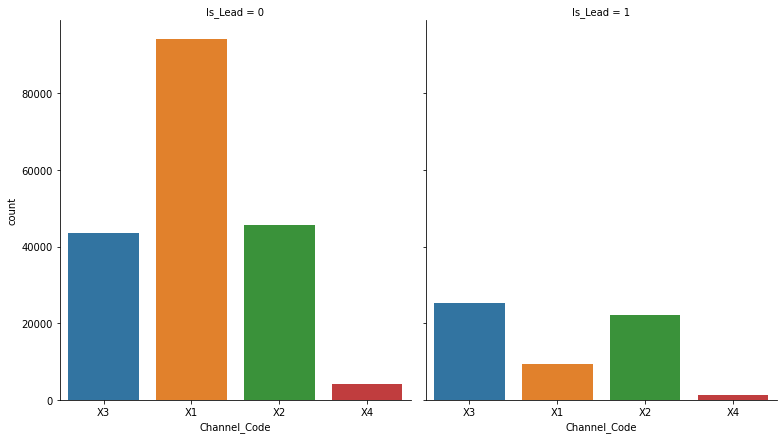

In [10]:
sns.catplot(x="Channel_Code", col="Is_Lead",
                data=train_raw, kind="count",
                height=6, aspect=.9)

In [11]:
sns.catplot(x="Credit_Product", col="Is_Lead",
                data=train_raw, kind="count",
                height=6, aspect=.9)

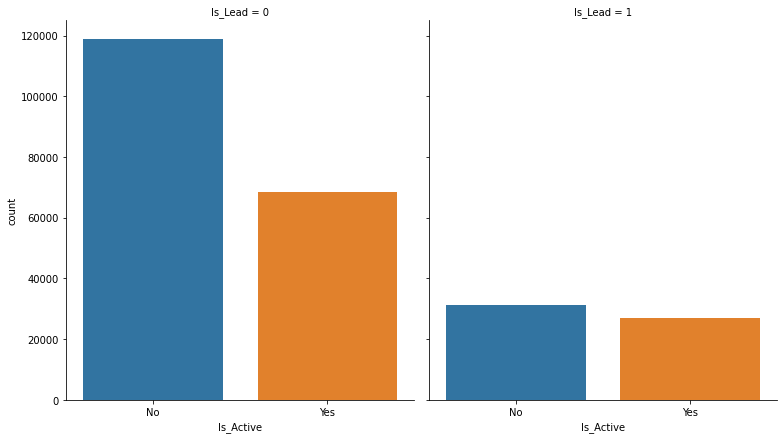

In [12]:
sns.catplot(x="Is_Active", col="Is_Lead",
                data=train_raw, kind="count",
                height=6, aspect=.9)

## Encoding Cat features

In [13]:
#Data encoding
train_raw['Gender']               = train_raw['Gender'].replace({'Female':0,'Male':1})
train_raw["Occupation"]           = train_raw["Occupation"].replace({"Self_Employed":1,"Salaried":2,"Other":3,"Entrepreneur":4})
train_raw["Channel_Code"]         = train_raw["Channel_Code"].replace({'X1':'1','X2':'2','X3':'3','X4':'4'})
train_raw["Credit_Product"]       = train_raw["Credit_Product"].replace({'No':'1','Yes':'2'})
train_raw["Is_Active"]            = train_raw["Is_Active"].replace({'No':'1','Yes':'2'})
train_raw["Region_Code"]          = train_raw["Region_Code"].apply(lambda x:x[2:])

In [14]:
train_raw["Region_Code"]      = pd.to_numeric(train_raw["Region_Code"])
train_raw["Channel_Code"]     = pd.to_numeric(train_raw["Channel_Code"])
train_raw["Credit_Product"]   = pd.to_numeric(train_raw["Credit_Product"])
train_raw["Is_Active"]        = pd.to_numeric(train_raw["Is_Active"])

# EDA (Exproratory Data Analysis)

## Numerical cols Distribution

In [15]:
train_raw.hist(bins=20, figsize=(20, 15))
plt.show()

## Scatter plot

In [16]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
sns.set_theme(style="darkgrid")
sns.scatterplot(x=train_raw.index, y=train_raw["Avg_Account_Balance"], hue=train_raw['Is_Lead'])

## Pair Plot

In [17]:
#bivariate analysis by plotting pair plot
#pair-plot
# plt.close()
# sns.set_style("whitegrid")
# sns.pairplot(train_raw, hue="Is_Lead", height=3)
# plt.show()

## Plotting the distributions of all the featuers

In [18]:
#Plotting the distributions of all the featuers

# Plotting numerical variable in displot to visualise the distribution
train_num = train_raw.select_dtypes(include='number')
var = list(train_num.columns.values)
# dropping Class columns from the list
var.remove("Is_Lead")

i = 0
t0 = train_raw.loc[train_raw['Is_Lead'] == 0]
t1 = train_raw.loc[train_raw['Is_Lead'] == 1]

plt.figure()
fig, ax = plt.subplots(2,5,figsize=(28,15))

for feature in var:
    i += 1
    plt.subplot(2,5,i)
    sns.kdeplot(t0[feature], bw=0.5, label="0")
    sns.kdeplot(t1[feature], bw=0.5, label="1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

In [19]:
# train_raw.drop(['Avg_Account_Balance'], axis=1, inplace=True) #dropping Avg_Account_Balance col

Avg_Account_Balance is highly overlapping

# Handling missing Values

In [20]:
# Checking for the missing value present in each columns
total = train_raw.isnull().sum().sort_values(ascending = False)
percent = (train_raw.isnull().sum()/train_raw.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

Credit_Product  Is_Lead  Is_Active  ...  Region_Code  Age  Gender
Total      29325.000000      0.0        0.0  ...          0.0  0.0     0.0
Percent       11.934073      0.0        0.0  ...          0.0  0.0     0.0

[2 rows x 10 columns]

In [21]:
#imputing Credit_Product Nan values with the new value 3
train_raw["Credit_Product"] = train_raw["Credit_Product"].fillna(3)

# again Checking for the missing value present in each columns
total = train_raw.isnull().sum().sort_values(ascending = False)
percent = (train_raw.isnull().sum()/train_raw.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

Is_Lead  Is_Active  Avg_Account_Balance  ...  Region_Code  Age  Gender
Total        0.0        0.0                  0.0  ...          0.0  0.0     0.0
Percent      0.0        0.0                  0.0  ...          0.0  0.0     0.0

[2 rows x 10 columns]

In [22]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.set_theme(style="darkgrid")
sns.kdeplot(data=train_raw, 
            x="Credit_Product", 
            hue="Is_Lead", 
            fill=True, 
            common_norm=False, 
            palette="crest",
            alpha=.5, 
            linewidth=0)

# Feature Engineering

In [23]:
train = train_raw.copy()
train.head(10)

Gender  Age  Region_Code  ...  Avg_Account_Balance  Is_Active  Is_Lead
0       0   73          268  ...              1045696          1        0
1       0   30          277  ...               581988          1        0
2       0   56          268  ...              1484315          2        0
3       1   34          270  ...               470454          1        0
4       0   30          282  ...               886787          1        0
5       1   56          261  ...               544163          2        0
6       1   62          282  ...              1056750          2        1
7       0   48          265  ...               444724          2        0
8       0   40          283  ...              1274284          1        0
9       0   55          268  ...              2014239          1        0

[10 rows x 10 columns]

## Binning on age

In [24]:
train.loc[train['Age'].idxmax()]

Gender                      1.0
Age                        85.0
Region_Code               282.0
Occupation                  3.0
Channel_Code                3.0
Vintage                   115.0
Credit_Product              2.0
Avg_Account_Balance    891513.0
Is_Active                   1.0
Is_Lead                     0.0
Name: 411, dtype: float64

Text(0, 0.5, 'Frequency')

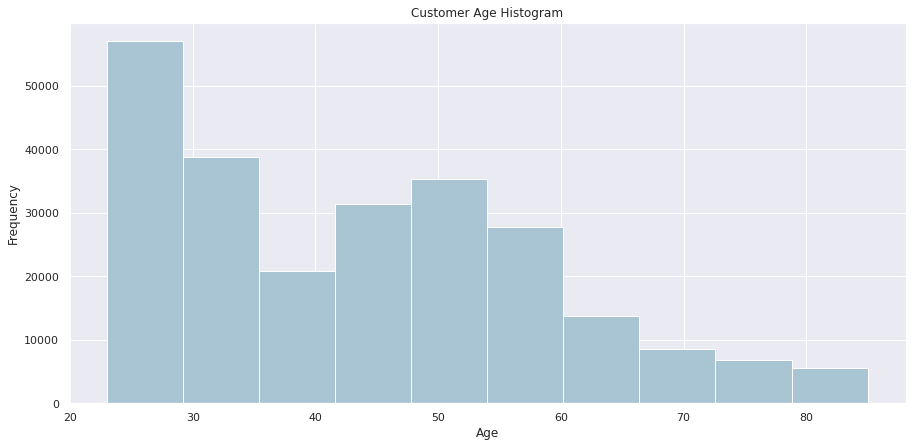

In [25]:
fig, ax = plt.subplots(figsize=(15,7))
train['Age'].hist(color='#A9C5D3')
ax.set_title('Customer Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

Age bins range

23 -  29  : 0

30 - 39  : 1

40 - 49  : 2

50 - 59  : 3

60 - 69  : 4

70 - 579  : 5

80 - 85  : 6

In [26]:
train['Age_bins'] = np.array(np.floor(np.array(train['Age']) / 10.))
train.iloc[20:25]

Gender  Age  Region_Code  ...  Is_Active  Is_Lead  Age_bins
20       1   44          269  ...          1        1       4.0
21       1   27          257  ...          1        0       2.0
22       0   32          279  ...          2        0       3.0
23       1   50          280  ...          2        0       5.0
24       0   31          282  ...          1        0       3.0

[5 rows x 11 columns]

## Binarization on Occupation
create a column, if there is a 4 in the occupation it will put 1 corresponds to 4

In [27]:
occupation_binary = np.array(train['Occupation'])
train['occupation_binary'] = train['Occupation'].map(lambda x: 1 if x == 4 else 0)
train.head(10)

Gender  Age  Region_Code  ...  Is_Lead  Age_bins  occupation_binary
0       0   73          268  ...        0       7.0                  0
1       0   30          277  ...        0       3.0                  0
2       0   56          268  ...        0       5.0                  0
3       1   34          270  ...        0       3.0                  0
4       0   30          282  ...        0       3.0                  0
5       1   56          261  ...        0       5.0                  0
6       1   62          282  ...        1       6.0                  0
7       0   48          265  ...        0       4.0                  0
8       0   40          283  ...        0       4.0                  0
9       0   55          268  ...        0       5.0                  0

[10 rows x 12 columns]

## Modifying vintage month to year

In [28]:
train['vintage_yr'] = np.array(np.floor(np.array(train['Vintage']) / 12.))
train.head(8)

Gender  Age  Region_Code  ...  Age_bins  occupation_binary  vintage_yr
0       0   73          268  ...       7.0                  0         3.0
1       0   30          277  ...       3.0                  0         2.0
2       0   56          268  ...       5.0                  0         2.0
3       1   34          270  ...       3.0                  0         1.0
4       0   30          282  ...       3.0                  0         2.0
5       1   56          261  ...       5.0                  0         2.0
6       1   62          282  ...       6.0                  0         1.0
7       0   48          265  ...       4.0                  0         1.0

[8 rows x 13 columns]

## Binarization on Credit product
create a column, if there is a 3 in the Credit product it will put 1 corresponds to 3

In [29]:
Credit_Product_binary = np.array(train['Credit_Product'])
train['Credit_Product_binary'] = train['Credit_Product'].map(lambda x: 1 if x == 3 else 0)
train.head()

Gender  Age  ...  vintage_yr  Credit_Product_binary
0       0   73  ...         3.0                      0
1       0   30  ...         2.0                      0
2       0   56  ...         2.0                      0
3       1   34  ...         1.0                      0
4       0   30  ...         2.0                      0

[5 rows x 14 columns]

## Binning Avg_Account_Balance with inter quartile range

Text(0, 0.5, 'Frequency')

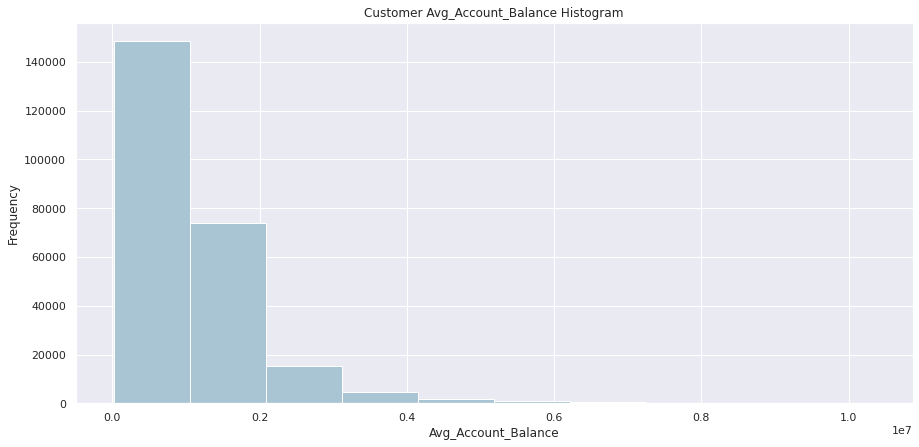

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
train['Avg_Account_Balance'].hist(color='#A9C5D3')
ax.set_title('Customer Avg_Account_Balance Histogram', fontsize=12)
ax.set_xlabel('Avg_Account_Balance', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [31]:
quantiles_range = [0, .25, .5, .75, 1.]
quantiles = train['Avg_Account_Balance'].quantile(quantiles_range)
quantiles

0.00       20790.0
0.25      604310.0
0.50      894601.0
0.75     1366666.0
1.00    10352009.0
Name: Avg_Account_Balance, dtype: float64

Text(0, 0.5, 'Frequency')

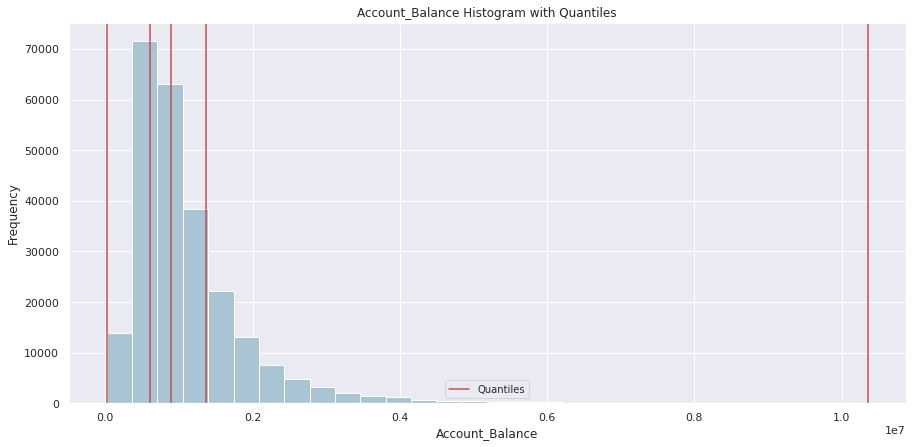

In [32]:
fig, ax = plt.subplots(figsize=(15,7))
train['Avg_Account_Balance'].hist(bins=30, color='#A9C5D3')

for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)

ax.set_title('Account_Balance Histogram with Quantiles', fontsize=12)
ax.set_xlabel('Account_Balance', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [33]:
quantile_labels = ['25', '50', '75', '100']
train['Avg_Account_Balance_quantile'] = pd.qcut(train['Avg_Account_Balance'], q=quantiles_range, labels=quantile_labels)
train.iloc[4:9]

Gender  Age  ...  Credit_Product_binary  Avg_Account_Balance_quantile
4       0   30  ...                      0                            50
5       1   56  ...                      0                            25
6       1   62  ...                      1                            75
7       0   48  ...                      0                            25
8       0   40  ...                      0                            75

[5 rows x 15 columns]

## log transformation on Avg_Account_Balance with inter quartile range

In [34]:
train['Avg_Account_Balance_log'] = np.log((1 + train['Avg_Account_Balance']))
train.iloc[4:9]

Gender  Age  ...  Avg_Account_Balance_quantile  Avg_Account_Balance_log
4       0   30  ...                            50                13.695361
5       1   56  ...                            25                13.207006
6       1   62  ...                            75                13.870710
7       0   48  ...                            25                13.005211
8       0   40  ...                            75                14.057896

[5 rows x 16 columns]

In [35]:
train['Avg_Account_Balance_quantile'] = pd.to_numeric(train["Avg_Account_Balance_quantile"])

## Create another column where convert the balance of last 12 months(1yr) balance into 1 month

In [36]:
train['Avg_Account_Balance_monthly'] = np.array(np.floor(np.array(train['Avg_Account_Balance']) / 12.))
train

Gender  Age  ...  Avg_Account_Balance_log  Avg_Account_Balance_monthly
0            0   73  ...                13.860194                      87141.0
1            0   30  ...                13.274207                      48499.0
2            0   56  ...                14.210465                     123692.0
3            1   34  ...                13.061456                      39204.0
4            0   30  ...                13.695361                      73898.0
...        ...  ...  ...                      ...                          ...
245720       1   51  ...                14.470741                     160465.0
245721       1   27  ...                13.668116                      71912.0
245722       0   26  ...                13.416018                      55888.0
245723       0   28  ...                12.917808                      33958.0
245724       1   29  ...                13.937088                      94106.0

[245725 rows x 17 columns]

## if Is_Active = 2(yes) which means customer is active in last three months. I'll put 3 corresponds to 2(yes) 

In [37]:
is_Active = np.array(train['Is_Active'])
train['is_Active_3(yes)'] = train['Is_Active'].map(lambda x: 1 if x == 2 else 0)
train.head(10)

Gender  Age  ...  Avg_Account_Balance_monthly  is_Active_3(yes)
0       0   73  ...                      87141.0                 0
1       0   30  ...                      48499.0                 0
2       0   56  ...                     123692.0                 1
3       1   34  ...                      39204.0                 0
4       0   30  ...                      73898.0                 0
5       1   56  ...                      45346.0                 1
6       1   62  ...                      88062.0                 1
7       0   48  ...                      37060.0                 1
8       0   40  ...                     106190.0                 0
9       0   55  ...                     167853.0                 0

[10 rows x 18 columns]

## Create columns that has product of weak features
5 weak features


1.   Age
2.   Vintage
3.   region code
4.   Avg_Account_Balance_quantile
5.   Avg_Account_Balance_log



It will create three more feature





In [38]:
train['combination1']   = train['Age']  * train['Vintage']
train['combination2']   = train['Vintage']  * train['Region_Code'] 
train['combination3']   = train['Region_Code'] * train['Age']
train['combination4']   = train['Age']  * train['Vintage'] * train['Region_Code']
train['combination5']   = train['Vintage']  * train['Region_Code'] * train['Avg_Account_Balance_quantile'] 
train['combination6']   = train['Avg_Account_Balance_quantile'] * train['Age']  * train['Avg_Account_Balance_log']
train

Gender  Age  Region_Code  ...  combination4  combination5  combination6
0            0   73          268  ...        841252        864300  75884.563282
1            0   30          277  ...        265920        221600   9955.655120
2            0   56          268  ...        390208        696800  79578.601861
3            1   34          270  ...        174420        128250  11102.237252
4            0   30          282  ...        279180        465300  20543.041837
...        ...  ...          ...  ...           ...           ...           ...
245720       1   51          284  ...       1578756       3095600  73800.781213
245721       1   27          268  ...        108540        201000  18451.955935
245722       0   26          281  ...         94978        182650  17440.822855
245723       0   28          273  ...        236964        211575   9042.465937
245724       1   29          269  ...        163821        423675  30313.166754

[245725 rows x 24 columns]

In [39]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.set_theme(style="darkgrid")
sns.kdeplot(data=train, 
            x="combination1", 
            hue="Is_Lead", 
            fill=True, 
            common_norm=False, 
            palette="crest",
            alpha=.5, 
            linewidth=0)

# Analysis on new Modified data

In [40]:
#Plotting the distributions of all the featuers

# Plotting numerical variable in displot to visualise the distribution
train_num = train.select_dtypes(include='number')
var = list(train_num.columns.values)
# dropping Class columns from the list
var.remove("Is_Lead")

i = 0
t0 = train.loc[train['Is_Lead'] == 0]
t1 = train.loc[train['Is_Lead'] == 1]

plt.figure()
fig, ax = plt.subplots(3,8,figsize=(28,15))

for feature in var:
    i += 1
    plt.subplot(3,8,i)
    sns.kdeplot(t0[feature], bw=0.5, label="0")
    sns.kdeplot(t1[feature], bw=0.5, label="1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

In [41]:
train.drop(['Avg_Account_Balance'], axis=1, inplace=True)
train.drop(['Avg_Account_Balance_log'], axis=1, inplace=True)
train.drop(['Avg_Account_Balance_monthly'], axis=1, inplace=True)

## Transformation

In [42]:
train.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Is_Active', 'Is_Lead', 'Age_bins',
       'occupation_binary', 'vintage_yr', 'Credit_Product_binary',
       'Avg_Account_Balance_quantile', 'is_Active_3(yes)', 'combination1',
       'combination2', 'combination3', 'combination4', 'combination5',
       'combination6'],
      dtype='object')

In [43]:
std_scl = preprocessing.StandardScaler() #instance of preprocessing

cols = ['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Is_Active', 'Age_bins',
       'occupation_binary', 'vintage_yr', 'Credit_Product_binary',
       'Avg_Account_Balance_quantile', 'is_Active_3(yes)', 'combination1',
       'combination2', 'combination3', 'combination4', 'combination5',
       'combination6']
train_scl = pd.DataFrame(std_scl.fit_transform(train[cols]), columns = cols)
train_scl['Is_Lead'] = train['Is_Lead']
train_scl['Is_Lead'].value_counts()
train_scl

Gender       Age  Region_Code  ...  combination5  combination6  Is_Lead
0      -1.096931  1.965365    -0.172389  ...      0.024771      1.428893        0
1      -1.096931 -0.934429     0.655830  ...     -0.793932     -1.155689        0
2      -1.096931  0.818935    -0.172389  ...     -0.188598      1.573709        0
3       0.911634 -0.664680     0.011660  ...     -0.912845     -1.110740        0
4      -1.096931 -0.934429     1.115951  ...     -0.483494     -0.740637        0
...          ...       ...          ...  ...           ...           ...      ...
245720  0.911634  0.481750     1.300000  ...      2.867112      1.347203        0
245721  0.911634 -1.136740    -0.172389  ...     -0.820173     -0.822613        0
245722 -1.096931 -1.204177     1.023927  ...     -0.843548     -0.862252        0
245723 -1.096931 -1.069303     0.287733  ...     -0.806702     -1.191489        0
245724  0.911634 -1.001866    -0.080365  ...     -0.536518     -0.357623        0

[245725 rows x 21 columns]

## check Skewness

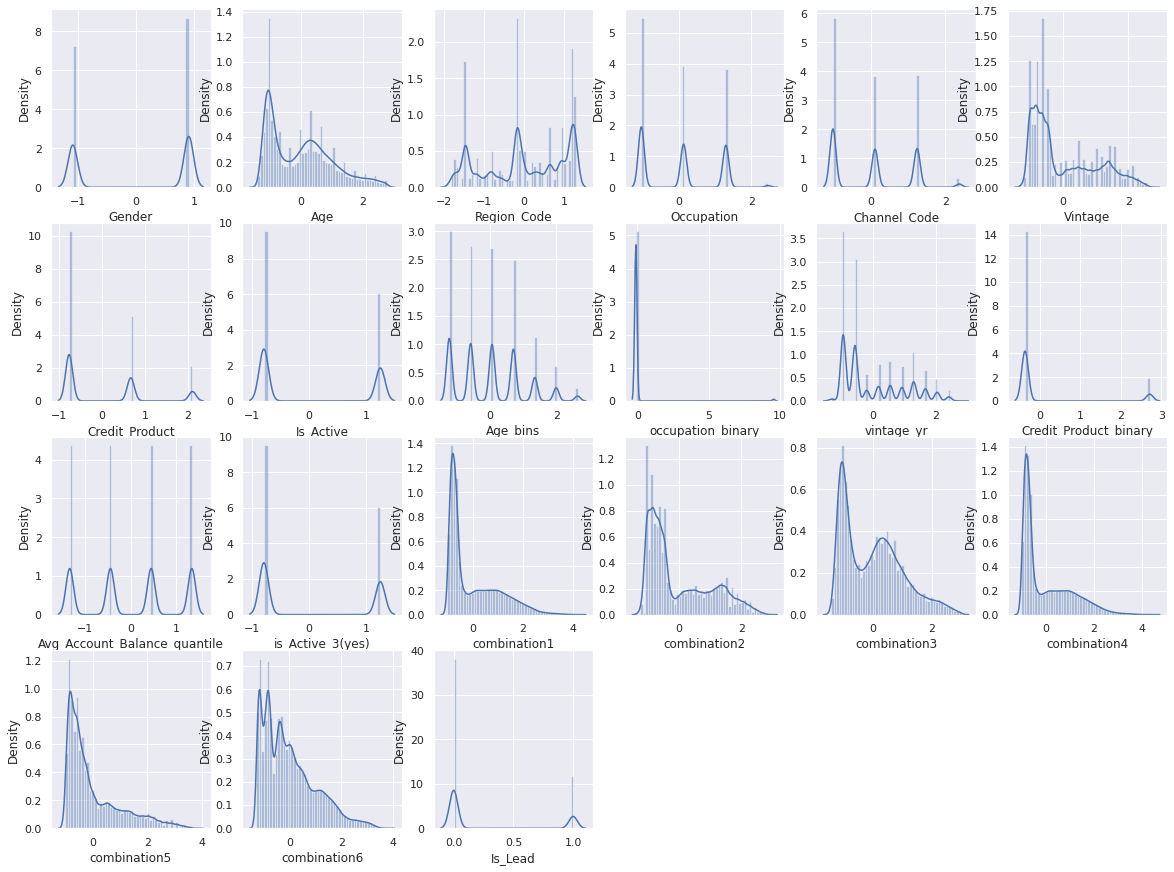

In [44]:
# plot the histogram of a variable from the dataset to see the skewness
var = train_scl.columns

plt.figure(figsize=(20,19))
i=0
for col in var:
    i += 1
    plt.subplot(5,6, i)
    sns.distplot(train_scl[col])

plt.show()

In [45]:
# Lets check the skewness of the features
var = train_scl.columns
skew_list = []
for i in var:
    skew_list.append(train_scl[i].skew())

tmp = pd.concat([pd.DataFrame(var, columns=["Features"]), pd.DataFrame(skew_list, columns=["Skewness"])], axis=1)
tmp.set_index("Features", inplace=True)
tmp.T

Features    Gender       Age  Region_Code  ...  combination5  combination6   Is_Lead
Skewness -0.185298  0.618992     -0.26556  ...      1.346272      0.905815  1.235596

[1 rows x 21 columns]

In [46]:
# Filtering the features which has skewness less than -1 and greater than +1
skewed = tmp.loc[(tmp["Skewness"] > 1) | (tmp["Skewness"] <-1 )].index
print(skewed)

Index(['occupation_binary', 'Credit_Product_binary', 'combination1',
       'combination4', 'combination5', 'Is_Lead'],
      dtype='object', name='Features')


In [47]:
# preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = PowerTransformer(copy=False)
# Fitting the power transformer in train data
train_scl['occupation_binary'] = pt.fit_transform(train_scl[['occupation_binary']])
train_scl['occupation_binary'] = pt.transform(train_scl[['occupation_binary']])

train_scl['Credit_Product_binary'] = pt.fit_transform(train_scl[['Credit_Product_binary']])
train_scl['Credit_Product_binary'] = pt.transform(train_scl[['Credit_Product_binary']])

train_scl['combination1'] = pt.fit_transform(train_scl[['combination1']])
train_scl['combination1'] = pt.transform(train_scl[['combination1']])

train_scl['combination4'] = pt.fit_transform(train_scl[['combination4']])
train_scl['combination4'] = pt.transform(train_scl[['combination4']])

train_scl['combination5'] = pt.fit_transform(train_scl[['combination5']])
train_scl['combination5'] = pt.transform(train_scl[['combination5']])

In [48]:
# plot the histogram of a variable from the dataset to see the skewness
var = train_scl.columns

plt.figure(figsize=(20,19))
i=0
for col in var:
    i += 1
    plt.subplot(5,6, i)
    sns.distplot(train_scl[col])

plt.show()

## Class analysis

In [49]:
classes = train_scl['Is_Lead'].value_counts()
islead_0 = round(classes[0]/train_scl['Is_Lead'].count()*100,2)
islead_1 = round(classes[1]/train_scl['Is_Lead'].count()*100, 2)
islead_0, islead_1

(76.28, 23.72)

In [50]:
# Create a bar plot for the number and percentage of islead_0 vs islead_1
plt.figure(figsize=(30,9))

plt.subplot(1,2,2)
islead_percentage = {'Class':['islead_0', 'islead_1'], 'Percentage':[islead_0, islead_1]} 
df_islead_percentage = pd.DataFrame(islead_percentage) 
sns.barplot(x='Class',y='Percentage', data=df_islead_percentage)
plt.title('Percentage of defaulters vs non-defaulters')

plt.show()

#Test data

In [51]:
test_raw     = pd.read_csv('/content/drive/MyDrive/AV jobathon may/test_mSzZ8RL.csv')
#Data encoding
test_raw['Gender']               = test_raw['Gender'].replace({'Female':0,'Male':1})
test_raw["Occupation"]           = test_raw["Occupation"].replace({"Self_Employed":1,"Salaried":2,"Other":3,"Entrepreneur":4})
test_raw["Channel_Code"]         = test_raw["Channel_Code"].replace({'X1':'1','X2':'2','X3':'3','X4':'4'})
test_raw["Credit_Product"]       = test_raw["Credit_Product"].replace({'No':'1','Yes':'2'})
test_raw["Is_Active"]            = test_raw["Is_Active"].replace({'No':'1','Yes':'2'})
test_raw["Region_Code"]          = test_raw["Region_Code"].apply(lambda x:x[2:])

test_raw["Credit_Product"] = test_raw["Credit_Product"].fillna(3)

test_raw["Region_Code"]      = pd.to_numeric(test_raw["Region_Code"])
test_raw["Channel_Code"]     = pd.to_numeric(test_raw["Channel_Code"])
test_raw["Credit_Product"]   = pd.to_numeric(test_raw["Credit_Product"])
test_raw["Is_Active"]        = pd.to_numeric(test_raw["Is_Active"])


test_raw['Age_bins'] = np.array(np.floor(np.array(test_raw['Age']) / 10.))

occupation_binary = np.array(test_raw['Occupation'])
test_raw['occupation_binary'] = test_raw['Occupation'].map(lambda x: 1 if x == 4 else 0)

test_raw['vintage_yr'] = np.array(np.floor(np.array(test_raw['Vintage']) / 12.))

Credit_Product_binary = np.array(test_raw['Credit_Product'])
test_raw['Credit_Product_binary'] = test_raw['Credit_Product'].map(lambda x: 1 if x == 3 else 0)

quantiles_range = [0, .25, .5, .75, 1.]
quantiles = test_raw['Avg_Account_Balance'].quantile(quantiles_range)
quantile_labels = ['25', '50', '75', '100']
test_raw['Avg_Account_Balance_quantile'] = pd.qcut(test_raw['Avg_Account_Balance'], q=quantiles_range, labels=quantile_labels)
test_raw['Avg_Account_Balance_quantile'] = pd.to_numeric(test_raw["Avg_Account_Balance_quantile"])

test_raw['Avg_Account_Balance_log'] = np.log((1 + test_raw['Avg_Account_Balance']))

test_raw['Avg_Account_Balance_monthly'] = np.array(np.floor(np.array(test_raw['Avg_Account_Balance']) / 12.))

is_Active = np.array(test_raw['Is_Active'])
test_raw['is_Active_3(yes)'] = test_raw['Is_Active'].map(lambda x: 3 if x == 2 else 0)

test_raw['combination1']   = test_raw['Age']  * test_raw['Vintage']
test_raw['combination2']   = test_raw['Vintage']  * test_raw['Region_Code'] 
test_raw['combination3']   = test_raw['Region_Code'] * test_raw['Age']
test_raw['combination4']   = test_raw['Age']  * test_raw['Vintage'] * test_raw['Region_Code']
test_raw['combination5']   = test_raw['Vintage']  * test_raw['Region_Code'] * test_raw['Avg_Account_Balance_quantile'] 
test_raw['combination6']   = test_raw['Avg_Account_Balance_quantile'] * test_raw['Age']  * test_raw['Avg_Account_Balance_log']

test_raw.drop(['ID'], axis = 1, inplace=True)
test_raw.drop(['Avg_Account_Balance'], axis = 1, inplace=True)
test_raw.drop(['Avg_Account_Balance_log'], axis=1, inplace=True)
test_raw.drop(['Avg_Account_Balance_monthly'], axis=1, inplace=True)

std_scl = preprocessing.StandardScaler() #instance of preprocessing
cols = test_raw.columns.values
test_scl = pd.DataFrame(std_scl.fit_transform(test_raw[cols]), columns = cols)

# Lets check the skewness of the features
var = test_scl.columns
skew_list = []
for i in var:
    skew_list.append(test_scl[i].skew())

tmp = pd.concat([pd.DataFrame(var, columns=["Features"]), pd.DataFrame(skew_list, columns=["Skewness"])], axis=1)
tmp.set_index("Features", inplace=True)

# Filtering the features which has skewness less than -1 and greater than +1
skewed = tmp.loc[(tmp["Skewness"] > 1) | (tmp["Skewness"] <-1 )].index
for i in skewed:
  # preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
  pt = PowerTransformer(copy=False)
  # Fitting the power transformer in train data
  test_scl[i] = pt.fit_transform(test_scl[[i]])
test_scl

Gender       Age  ...  combination5  combination6
0       0.908299 -0.999878  ...     -0.718565     -0.778098
1       0.908299 -0.058563  ...      0.651221      0.191249
2       0.908299 -0.865404  ...     -1.447281     -1.173659
3       0.908299 -0.999878  ...     -0.355746     -0.769198
4      -1.100959 -0.999878  ...     -0.903657     -0.785041
...          ...       ...  ...           ...           ...
105307  0.908299  0.546567  ...      1.570821      1.566507
105308  0.908299  0.748278  ...      1.320043      0.712816
105309  0.908299 -0.596457  ...     -0.537080      0.423284
105310  0.908299  0.613804  ...      0.868849     -0.142360
105311  0.908299 -1.134351  ...     -1.306289     -1.195164

[105312 rows x 20 columns]

# Model Building

In [52]:
# Creating function to display ROC-AUC score, f1 score and classification report
def display_scores(y_test, y_pred):
    '''
    Display ROC-AUC score, f1 score and classification report of a model.
    '''
    print(f"F1 Score: {round(f1_score(y_test, y_pred)*100,2)}%") 
    print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

In [53]:
# ROC Curve function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(12, 10))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [54]:
cols

array(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Is_Active', 'Age_bins',
       'occupation_binary', 'vintage_yr', 'Credit_Product_binary',
       'Avg_Account_Balance_quantile', 'is_Active_3(yes)', 'combination1',
       'combination2', 'combination3', 'combination4', 'combination5',
       'combination6'], dtype=object)

In [55]:
X = train_scl[cols]
y = train_scl['Is_Lead']

In [56]:
# Spltting the into 80:20 train test size
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(196580, 20)
(49145, 20)
(196580,)
(49145,)


## XGboost

In [72]:
# specify model
params = {'learning_rate': 0.003,
          'max_depth': 100, 
          'n_estimators':200,
          'subsample':0.3,
          'eval_metric' : 'auc',
         'objective':'binary:logistic'}
xgb_model = XGBClassifier(params = params)
# fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'eval_metric': 'auc', 'learning_rate': 0.6,
                      'max_depth': 100, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.3},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [83]:
xgb_model.score(X_train, y_train)

0.8600925831722454

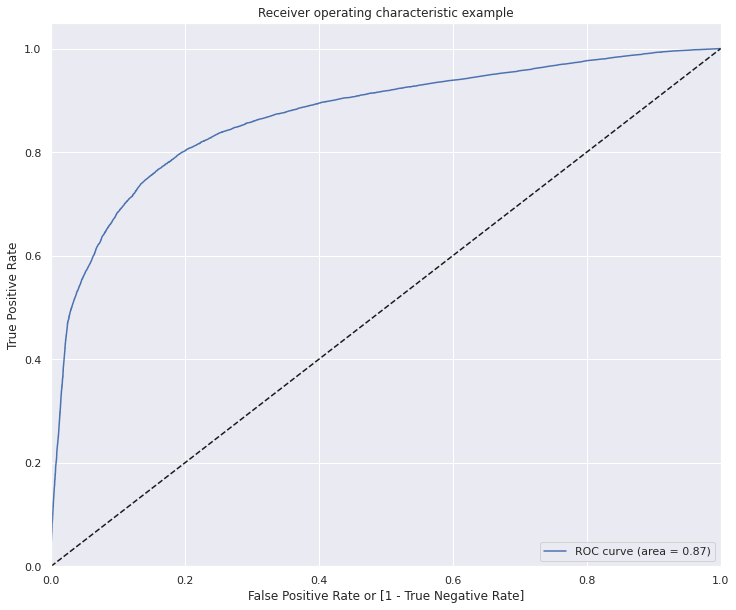

In [84]:
# Predicted probability
y_pred = xgb_model.predict_proba(X_val)[:,1]

# Plot the ROC curve
draw_roc(y_val, y_pred)

In [85]:
xgb_test_preds = xgb_model.predict_proba(test_scl)[:,1]
sub['Is_Lead'] = pd.Series(xgb_test_preds)
sub.to_csv('s_xb6.csv', index=False)
sub

ID   Is_Lead
0       VBENBARO  0.063826
1       CCMEWNKY  0.853099
2       VK3KGA9M  0.053940
3       TT8RPZVC  0.025816
4       SHQZEYTZ  0.025816
...          ...       ...
105307  DBENJOYI  0.924546
105308  CWQ72DWS  0.541402
105309  HDESC8GU  0.092822
105310  2PW4SFCA  0.260305
105311  F2NOYPPZ  0.050371

[105312 rows x 2 columns]

## other models

In [57]:
!pip install catboost

     |████████████████████████████████| 67.3MB 56kB/s 


In [58]:
from catboost import CatBoostClassifier,Pool, cv
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### LGM classifier

In [92]:
lgm = LGBMClassifier(n_estimators=5000,
                   random_state=1994,
                   learning_rate=0.01,
                   colsample_bytree=0.5,
                   reg_alpha=4,
                   min_split_gain=0.2,
                   min_child_samples=2,
                   bagging_fraction=0.9,
                   max_depth=100)

lgm.fit(X_train,y_train, eval_set=[(X_val, y_val)], eval_metric='AUC', early_stopping_rounds=200, verbose=200)
p = lgm.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val, p))

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.363365	valid_0's auc: 0.869432
[400]	valid_0's binary_logloss: 0.348312	valid_0's auc: 0.871683
[600]	valid_0's binary_logloss: 0.346219	valid_0's auc: 0.872143
[800]	valid_0's binary_logloss: 0.345817	valid_0's auc: 0.872176
[1000]	valid_0's binary_logloss: 0.345736	valid_0's auc: 0.872164
Early stopping, best iteration is:
[826]	valid_0's binary_logloss: 0.345787	valid_0's auc: 0.872197
0.8721973427791916


In [93]:
lgm_test_preds = lgm.predict_proba(test_scl)[:,1]
sub['Is_Lead'] = pd.Series(lgm_test_preds)
sub.to_csv('s_lgm1.csv', index=False)

### Catboost

In [94]:
cb = CatBoostClassifier(n_estimators=3000, 
                        random_state=1994,
                        eval_metric='AUC',
                        learning_rate=0.01,
                        random_strength=200,
                        bagging_temperature=0.6,
                        l2_leaf_reg=4,
                        one_hot_max_size=10)

cb.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=100, verbose=200)
p = cb.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,p))

0:	test: 0.7838189	test1: 0.7819621	best: 0.7819621 (0)	total: 148ms	remaining: 7m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8558852867
bestIteration = 4

Shrink model to first 5 iterations.
0.8558852867001399


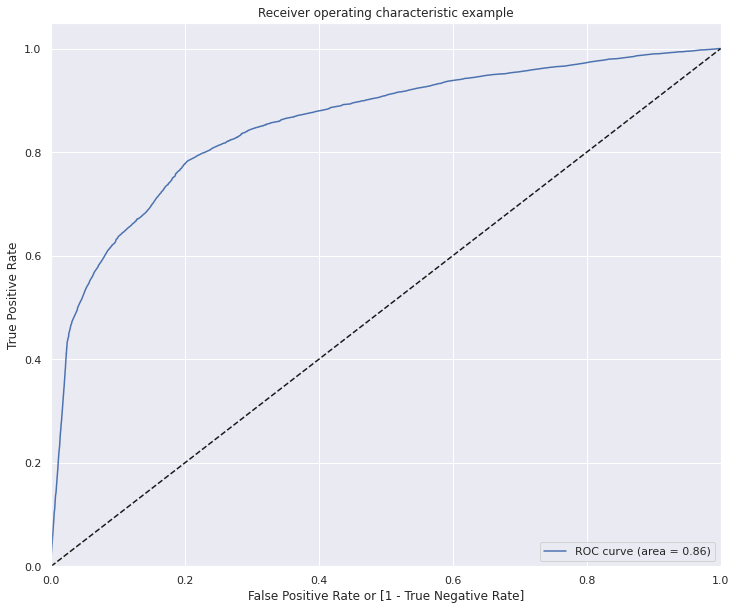

In [95]:
# Plot the ROC curve
draw_roc(y_val, p)

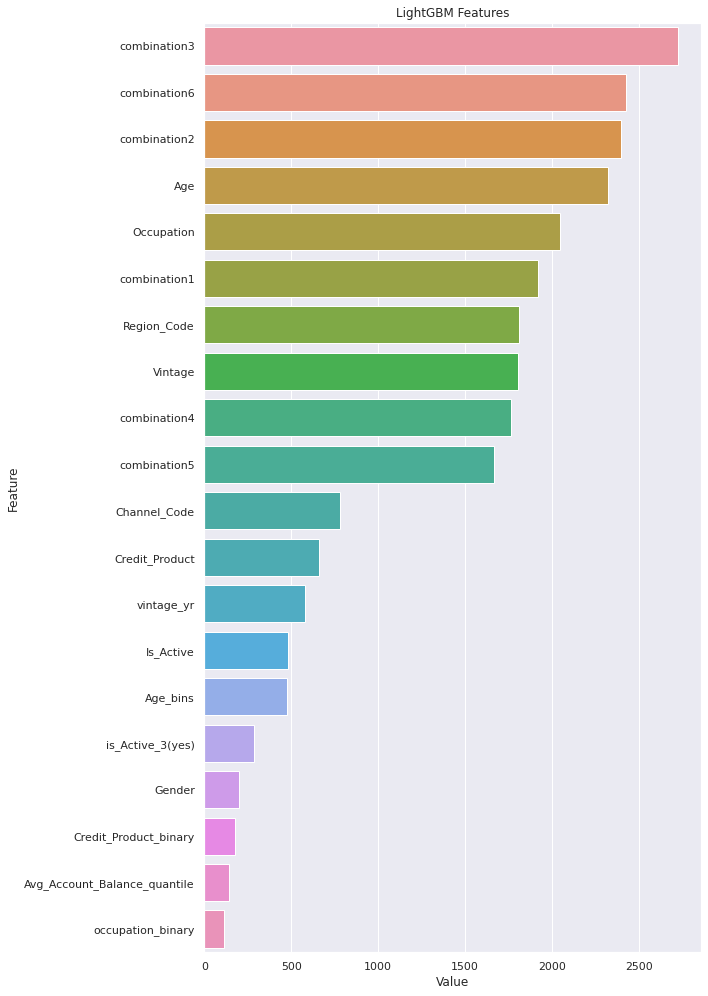

In [96]:
feature_imp = pd.DataFrame(sorted(zip(lgm.feature_importances_, X.columns), reverse=True)[:200], 
                           columns=['Value','Feature'])
plt.figure(figsize=(10,14))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [59]:
!pip install shap

     |████████████████████████████████| 358kB 24.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491631 sha256=14403cb63aa89c7e2c879bba28a11c876a036757302cb86fa57554c8f099e901
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


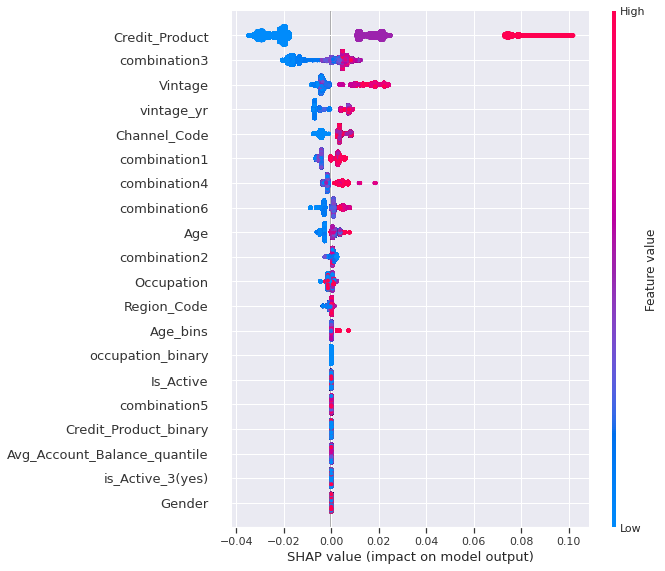

column_name shap_importance
6                 Credit_Product       0.0289531
16                  combination3      0.00823036
5                        Vintage      0.00697346
10                    vintage_yr      0.00654804
4                   Channel_Code      0.00455595
14                  combination1      0.00381459
17                  combination4      0.00309378
19                  combination6      0.00264961
1                            Age      0.00179721
15                  combination2     0.000947897
3                     Occupation      0.00092131
2                    Region_Code     0.000353417
8                       Age_bins     8.12726e-05
9              occupation_binary               0
11         Credit_Product_binary               0
12  Avg_Account_Balance_quantile               0
13              is_Active_3(yes)               0
7                      Is_Active               0
18                  combination5               0
0                         Gender               0

In [98]:
import shap
shap.initjs()

shap_values = shap.TreeExplainer(cb).shap_values(X)

shap.summary_plot(shap_values, X)


shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [ ]:
test_preds = m.predict_proba(test_scl, ntree_end=m.best_iteration_)[:,-1]

sub['Is_Lead'] = pd.Series(test_preds)
sub.to_csv('s_cb2.csv', index=False)

In [60]:
err=[]
y_pred_tot=[]

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
fold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
for train_index, val_index in fold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    m = CatBoostClassifier(n_estimators=3000,random_state=1994,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=10)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=100,verbose=200)
    
    preds = m.predict_proba(X_val,ntree_end=m.best_iteration_)[:,-1]
    print("err: ",roc_auc_score(y_val, preds))
    err.append(roc_auc_score(y_val, preds))

0:	test: 0.8074189	test1: 0.8086865	best: 0.8086865 (0)	total: 161ms	remaining: 8m 1s
200:	test: 0.8680707	test1: 0.8681201	best: 0.8681256 (199)	total: 23s	remaining: 5m 20s
400:	test: 0.8758067	test1: 0.8741321	best: 0.8741321 (400)	total: 45.9s	remaining: 4m 57s
600:	test: 0.8789011	test1: 0.8743639	best: 0.8744103 (565)	total: 1m 9s	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8744103265
bestIteration = 565

Shrink model to first 566 iterations.
err:  0.8744017139639201
0:	test: 0.8068078	test1: 0.8119398	best: 0.8119398 (0)	total: 107ms	remaining: 5m 20s
200:	test: 0.8670487	test1: 0.8716107	best: 0.8716135 (199)	total: 22.7s	remaining: 5m 16s
400:	test: 0.8753603	test1: 0.8780696	best: 0.8780735 (399)	total: 45.6s	remaining: 4m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8781457519
bestIteration = 411

Shrink model to first 412 iterations.
err:  0.8781349975950673
0:	test: 0.8073735	test1: 0.8057256	best: 0.80

this gave 0.85237072

In [61]:
test_preds = m.predict_proba(test_scl, ntree_end=m.best_iteration_)[:,1]

sub['Is_Lead'] = pd.Series(test_preds)
sub.to_csv('s_cb4(best_continu).csv', index=False)

### XGB gridcv

In [62]:
# creating a KFold object 
folds = 4

# specify range of hyperparameters
param_grid = {'learning_rate': [0.01, 0.6, 0.9], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=8, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 42.7min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.6, 0.9],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_

In [63]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0     135.171465      0.624563  ...          0.882364         0.000381
1     151.270751      0.108219  ...          0.883146         0.000260
2     143.551272      1.089422  ...          0.882847         0.000159
3     127.296154      0.440140  ...          0.921122         0.000934
4     142.772329      0.462811  ...          0.957416         0.000756
5     127.993730      0.790059  ...          0.962817         0.000770
6     125.204743      0.766132  ...          0.895408         0.001907
7     144.894446      0.615403  ...          0.962432         0.000366
8     129.928871      0.626422  ...          0.975795         0.000346

[9 rows x 20 columns]

In [64]:
# Printing the optimal score and hyperparameters
print("Best roc auc score : ", model_cv.best_score_)
print(model_cv.best_estimator_)

Best roc auc score :  0.8723106184649777
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)


In [65]:
model_cv.best_params_

{'learning_rate': 0.01, 'subsample': 0.6}

In [66]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
# params = {'learning_rate': 0.01,
#           'max_depth': 8, 
#           'n_estimators':200,
#           'subsample':0.6,
#          'objective':'binary:logistic'}

# fit model on training data
xgb_cv = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
xgb_cv.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [67]:
y_val_pred = xgb_cv.predict(X_val)
display_scores(y_val, y_val_pred)

F1 Score: 64.62%
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     18743
           1       0.81      0.54      0.65      5829

    accuracy                           0.86     24572
   macro avg       0.84      0.75      0.78     24572
weighted avg       0.85      0.86      0.85     24572



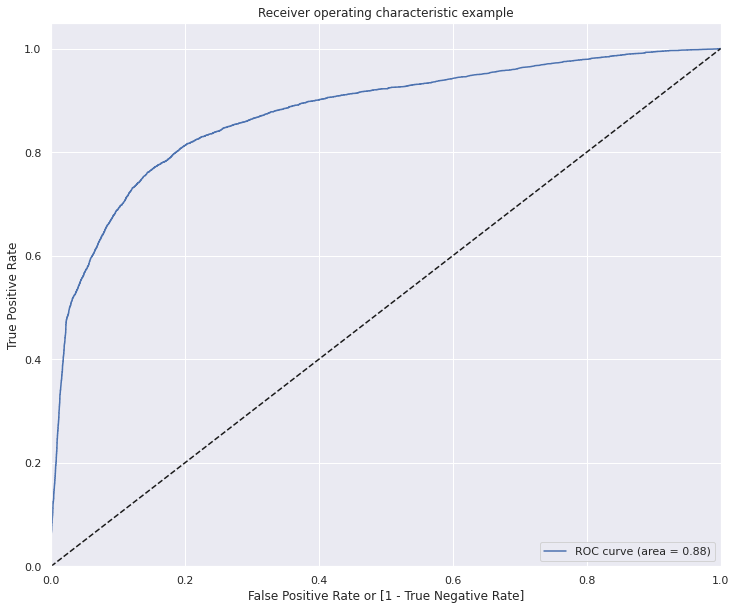

In [68]:
# Predicted probability
y_val_pred_proba = xgb_cv.predict_proba(X_val)[:,1]
# Plot the ROC curve
draw_roc(y_val, y_val_pred_proba)

In [69]:
test_preds = xgb_cv.predict_proba(test_scl)[:,1]
sub['Is_Lead'] = pd.Series(test_preds)
sub.to_csv('s_xb_cv3.csv', index=False)

# Dealing with imbalance Data

## Random Oversampling

In [70]:
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [71]:
from collections import Counter
# Befor sampling class distribution
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_over))

Before sampling class distribution:- Counter({0: 168694, 1: 52459})
New class distribution:- Counter({0: 168694, 1: 168694})


### Decision Tree

In [146]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           n_jobs=-1,
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_over, y_over)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.6s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         

In [147]:
# Printing the optimal roc score and hyperparameters
print("Best roc auc score : ", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc auc score :  0.87582533181057
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [148]:
# Model with optimal hyperparameters
dt_over_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=100,
                                  min_samples_split=100)

dt_over_model.fit(X_over, y_over)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [149]:
# Predictions on the val set
y_val_pred = dt_over_model.predict(X_val)
display_scores(y_val, y_val_pred)

F1 Score: 66.51%
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87     18743
           1       0.58      0.78      0.67      5829

    accuracy                           0.81     24572
   macro avg       0.75      0.80      0.77     24572
weighted avg       0.84      0.81      0.82     24572



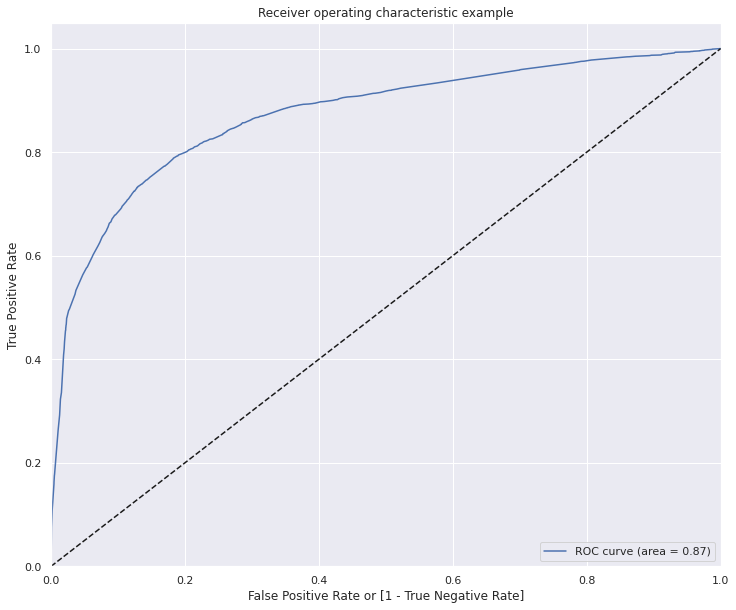

In [150]:
# Predicted probability
y_val_pred_proba = dt_over_model.predict_proba(X_val)[:,1]
# Plot the ROC curve
draw_roc(y_val, y_val_pred_proba)

### Xgboost

In [152]:
# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=10, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_over, y_over) 

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 28.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [153]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0     177.702571      0.158273  ...          0.941550         0.002401
1     193.855589      0.761689  ...          0.950858         0.001417
2     171.274967      0.211973  ...          0.949831         0.001508
3     179.044271      0.138474  ...          0.956445         0.002963
4     196.774727      0.183036  ...          0.977355         0.001472
5     175.007733      0.540380  ...          0.981757         0.001261

[6 rows x 18 columns]

In [154]:
# Printing the optimal score and hyperparameters
print("Best roc auc score : ", model_cv.best_score_)
print(model_cv.best_estimator_)

Best roc auc score :  0.9350012589513893
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.6, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)


In [155]:
model_cv.best_params_

{'learning_rate': 0.6, 'subsample': 0.9}

In [73]:
# chosen hyperparameters
params = {'learning_rate': 0.01,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
xgb_over_model = XGBClassifier(params = params)
xgb_over_model.fit(X_over, y_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.01, 'max_depth': 2,
                      'n_estimators': 200, 'objective': 'binary:logistic',
                      'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [74]:
# Predictions on the val set
y_val_pred = xgb_over_model.predict(X_val.to_numpy())

display_scores(y_val, y_val_pred)

F1 Score: 67.41%
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.83      0.88     18743
           1       0.59      0.78      0.67      5829

    accuracy                           0.82     24572
   macro avg       0.76      0.81      0.78     24572
weighted avg       0.85      0.82      0.83     24572



In [75]:
# Predictions on the train set
y_train_pred = xgb_over_model.predict(X_over)

display_scores(y_over, y_train_pred)

F1 Score: 79.91%
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81    168694
           1       0.82      0.78      0.80    168694

    accuracy                           0.80    337388
   macro avg       0.81      0.80      0.80    337388
weighted avg       0.81      0.80      0.80    337388



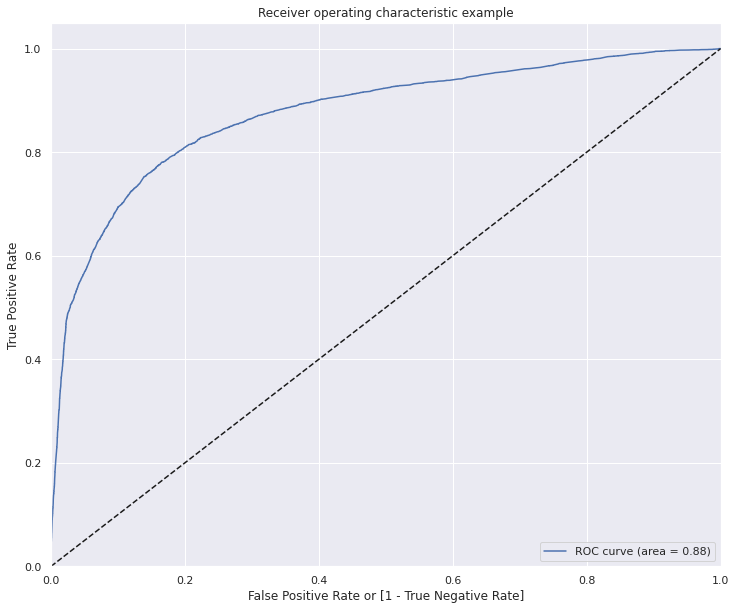

In [76]:
# Predicted probability
y_val_pred_proba = xgb_over_model.predict_proba(X_val.to_numpy())[:,1]
# Plot the ROC curve
draw_roc(y_val, y_val_pred_proba)

In [79]:
test_preds = xgb_over_model.predict_proba(test_scl.to_numpy())[:,1]
sub['Is_Lead'] = pd.Series(test_preds)
sub.to_csv('s_xb_(RS).csv', index=False)

### catboost

In [163]:
err=[]
y_pred_tot=[]

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
fold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
for train_index, val_index in fold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    m = CatBoostClassifier(n_estimators=3000,random_state=1994,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=10)
    m.fit(X_over, y_over,eval_set=[(X_over, y_over),(X_val, y_val)], early_stopping_rounds=100,verbose=200)
    
    preds = m.predict_proba(X_val,ntree_end=m.best_iteration_)[:,-1]
    print("err: ",roc_auc_score(y_val, preds))
    err.append(roc_auc_score(y_val, preds))

0:	test: 0.8031823	test1: 0.8054541	best: 0.8054541 (0)	total: 160ms	remaining: 7m 59s
200:	test: 0.8699101	test1: 0.8709928	best: 0.8709961 (199)	total: 30.5s	remaining: 7m 4s
400:	test: 0.8757950	test1: 0.8758903	best: 0.8758903 (400)	total: 1m 1s	remaining: 6m 37s
600:	test: 0.8795687	test1: 0.8790045	best: 0.8790045 (600)	total: 1m 32s	remaining: 6m 10s
800:	test: 0.8823645	test1: 0.8812966	best: 0.8812966 (800)	total: 2m 4s	remaining: 5m 41s
1000:	test: 0.8845692	test1: 0.8832992	best: 0.8832992 (1000)	total: 2m 35s	remaining: 5m 11s
1200:	test: 0.8865896	test1: 0.8851033	best: 0.8851033 (1200)	total: 3m 7s	remaining: 4m 40s
1400:	test: 0.8884657	test1: 0.8869410	best: 0.8869410 (1400)	total: 3m 38s	remaining: 4m 9s
1600:	test: 0.8901904	test1: 0.8883752	best: 0.8883752 (1600)	total: 4m 10s	remaining: 3m 38s
1800:	test: 0.8917904	test1: 0.8898258	best: 0.8898258 (1800)	total: 4m 41s	remaining: 3m 7s
2000:	test: 0.8932595	test1: 0.8912204	best: 0.8912204 (2000)	total: 5m 13s	remain

In [164]:
test_preds = m.predict_proba(test_scl, ntree_end=m.best_iteration_)[:,-1]

sub['Is_Lead'] = pd.Series(test_preds)
sub.to_csv('s_cb3.csv', index=False)

### Stacked Ensemble

In [ ]:
# !pip install sklearn2pmml

In [214]:
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn2pmml.pipeline import PMMLPipeline

from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn2pmml.pipeline import PMMLPipeline

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [223]:
estimators = [
              ("LGBM", LGBMClassifier(n_estimators = 31, max_depth = 3, random_state = 13)),
              ("XGB", XGBClassifier(n_estimators = 31, max_depth = 3, random_state = 13))
]
clf = StackingClassifier(
                          estimators=estimators, final_estimator=XGBClassifier()
)
clf.fit(X_over, y_over).score(X_val.to_numpy(), y_val)

0.8073416897281459

In [229]:
test_preds = clf.predict_proba(test_scl.to_numpy())[:,-1]

sub['Is_Lead'] = pd.Series(test_preds)
sub.to_csv('clf_stacked.csv', index=False)

## SMOTE (Synthetic Minority Oversampling Technique)

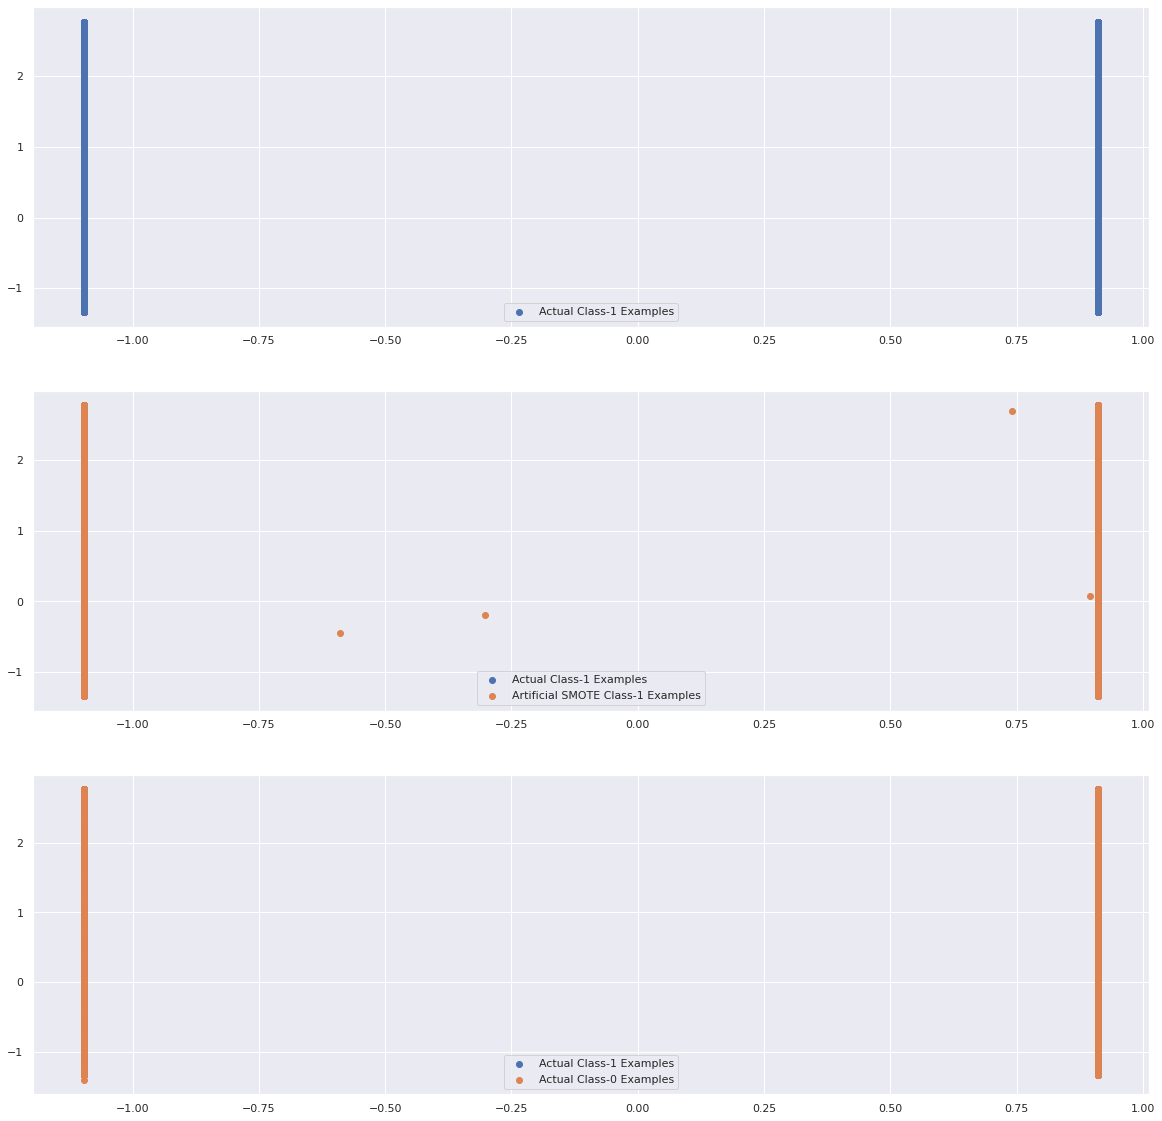

In [166]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### Decision Tree SMOTE

In [168]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           n_jobs=-1,
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_smote,y_train_smote)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   21.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         

In [171]:
# Printing the optimal roc score and hyperparameters
print("Best roc auc score : ", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc auc score :  0.8882911056444649
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [172]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 100}

In [173]:
# Model with optimal hyperparameters
dt_smote_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)

dt_smote_model.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

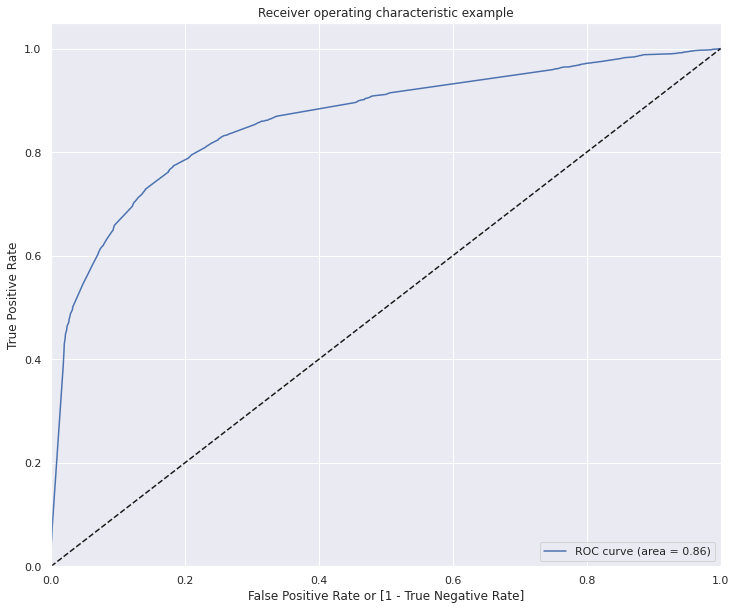

In [175]:
# Predicted probability
y_val_pred_smote = dt_smote_model.predict_proba(X_val)[:,1]
# Plot the ROC curve
draw_roc(y_val, y_val_pred_smote)

### xgboost SMOTE

In [177]:
# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=100)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

In [178]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0      18.487444      0.110450  ...          0.910435         0.019957
1      20.758753      0.204009  ...          0.909953         0.019264
2      19.501824      0.396119  ...          0.909807         0.018801
3      18.354543      0.225732  ...          0.939495         0.029303
4      20.786181      0.199218  ...          0.939907         0.027937
5      19.207680      0.682407  ...          0.941128         0.028801

[6 rows x 18 columns]

In [179]:
# Printing the optimal score and hyperparameters
print("Best roc auc score : ", model_cv.best_score_)
print(model_cv.best_estimator_)

Best roc auc score :  0.9292754712948273
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.6, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)


In [180]:
model_cv.best_params_

{'learning_rate': 0.6, 'subsample': 0.9}

In [181]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
params = {'learning_rate': 0.6,
          'max_depth': 2, 
          'n_estimators':100,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
xgb_smote_model = XGBClassifier(params = params)
xgb_smote_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.6, 'max_depth': 2, 'n_estimators': 100,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

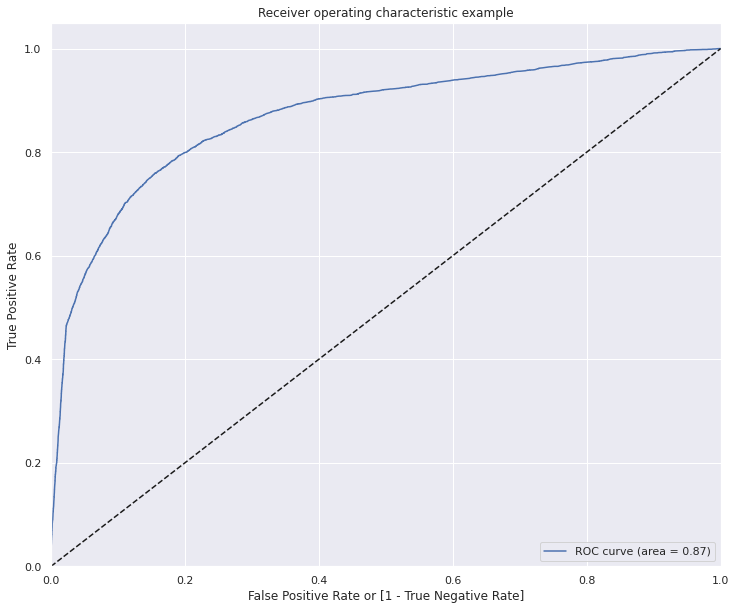

In [183]:
# Predicted probability
y_val_pred_smote = xgb_smote_model.predict_proba(X_val.to_numpy())[:,1]
# Plot the ROC curve
draw_roc(y_val, y_val_pred_smote)

### Catboost SMOTE

In [201]:
err=[]
y_pred_tot=[]

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
fold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
for train_index, val_index in fold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    m = CatBoostClassifier(n_estimators=3000,random_state=1994,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=10)
    m.fit(X_train_smote, y_train_smote,eval_set=[(X_train_smote, y_train_smote),(X_val, y_val)], early_stopping_rounds=100,verbose=200)
    
    preds = m.predict_proba(X_val,ntree_end=m.best_iteration_)[:,-1]
    print("err: ",roc_auc_score(y_val, preds))
    err.append(roc_auc_score(y_val, preds))

0:	test: 0.7126821	test1: 0.7089056	best: 0.7089056 (0)	total: 139ms	remaining: 6m 58s
200:	test: 0.8748408	test1: 0.8714578	best: 0.8714579 (198)	total: 31.9s	remaining: 7m 24s
400:	test: 0.9249900	test1: 0.8732280	best: 0.8733924 (311)	total: 1m 3s	remaining: 6m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8733923946
bestIteration = 311

Shrink model to first 312 iterations.
err:  0.8733889806709898
0:	test: 0.7126821	test1: 0.7146408	best: 0.7146408 (0)	total: 132ms	remaining: 6m 35s
200:	test: 0.8748408	test1: 0.8761317	best: 0.8761317 (200)	total: 32s	remaining: 7m 25s
400:	test: 0.9249900	test1: 0.8780998	best: 0.8783035 (380)	total: 1m 3s	remaining: 6m 53s
600:	test: 0.9502825	test1: 0.8795304	best: 0.8795611 (591)	total: 1m 35s	remaining: 6m 22s
800:	test: 0.9555141	test1: 0.8805181	best: 0.8805259 (799)	total: 2m 7s	remaining: 5m 49s
1000:	test: 0.9574056	test1: 0.8814556	best: 0.8814563 (997)	total: 2m 38s	remaining: 5m 17s
1200:	test: 0.9585654	te

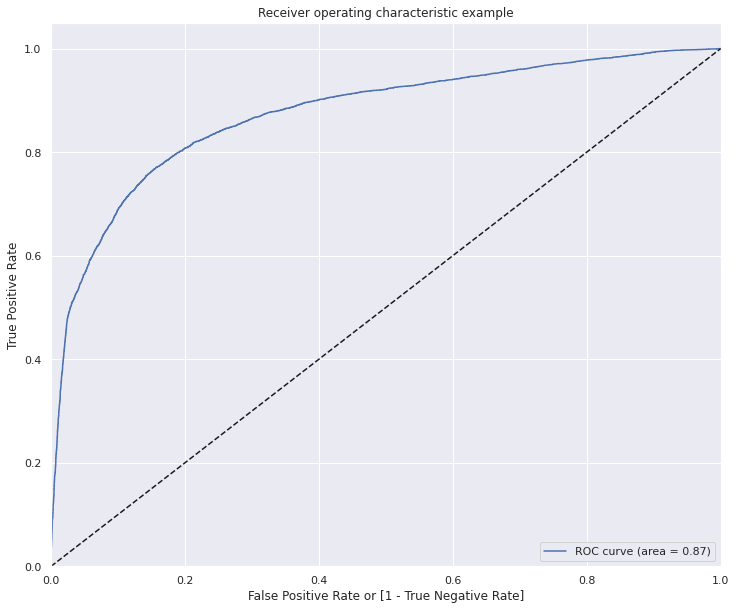

In [202]:
# Predicted probability
y_val_pred_smote = m.predict_proba(X_val)[:,1]
# Plot the ROC curve
draw_roc(y_val, y_val_pred_smote)

In [203]:
test_preds = m.predict_proba(test_scl, ntree_end=m.best_iteration_)[:,-1]

sub['Is_Lead'] = pd.Series(test_preds)
sub.to_csv('s_cb_smte.csv', index=False)

### LightGM classifier SMOTE

In [204]:
m = LGBMClassifier(n_estimators=5000,
                   random_state=1994,
                   learning_rate=0.05,
                   colsample_bytree=0.5,
                   reg_alpha=4,
                   min_split_gain=0.2,
                   min_child_samples=2,
                   bagging_fraction=0.9,
                   max_depth=-1)

m.fit(X_train_smote, y_train_smote, eval_set=[(X_val, y_val)], eval_metric='AUC', early_stopping_rounds=200, verbose=200)
p = m.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val, p))

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.353702	valid_0's auc: 0.875424
[400]	valid_0's binary_logloss: 0.345889	valid_0's auc: 0.875423
Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.347418	valid_0's auc: 0.875534
0.875533654941134


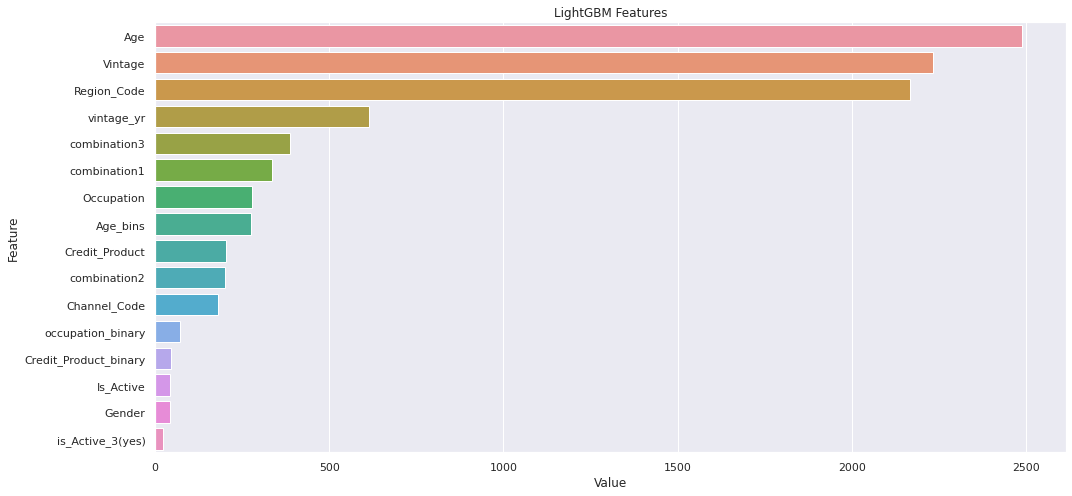

In [206]:
feature_imp = pd.DataFrame(sorted(zip(m.feature_importances_, X.columns), reverse=True)[:200], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## ADASYN (Adaptive Synthetic Sampling)

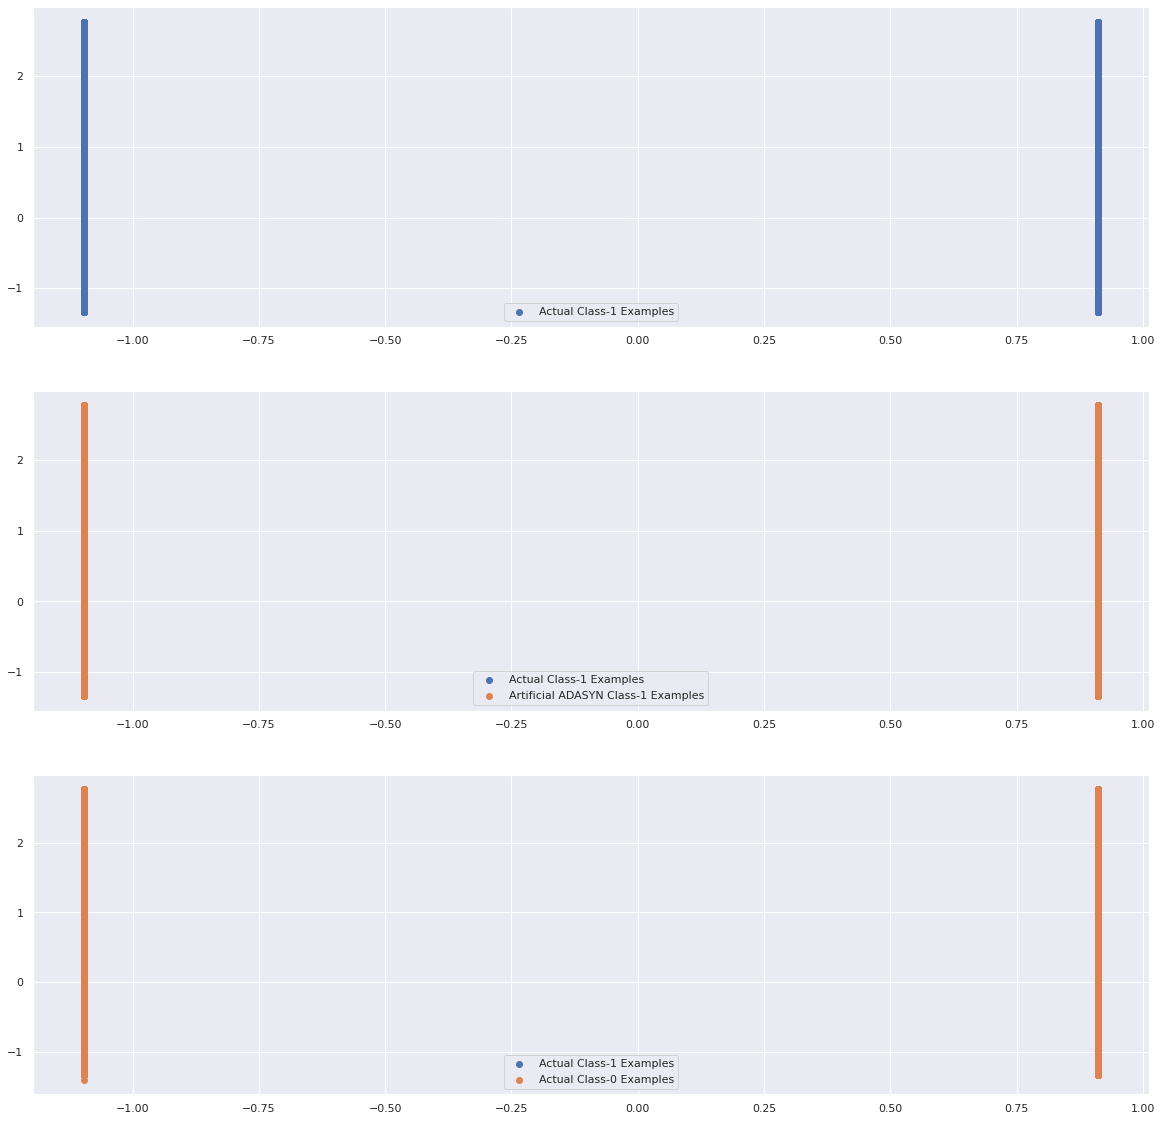

In [185]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### Decision Tree ADASYN

In [186]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 5, 
                           n_jobs=-1,
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_adasyn, y_train_adasyn)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   39.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         

In [187]:
# Printing the optimal roc score and hyperparameters
print("Best roc auc score : ", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc auc score :  0.8411111174172612
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [188]:
# Model with optimal hyperparameters
dt_adasyn_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_adasyn_model.fit(X_train_adasyn, y_train_adasyn)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [189]:
# Predicted probability
y_val_pred_proba = dt_adasyn_model.predict_proba(X_val)[:,1]
# Plot the ROC curve
draw_roc(y_val, y_val_pred_proba)

### Xgboost ADASYN

In [191]:
# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs=-1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_adasyn, y_train_adasyn)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

In [192]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0      35.140637      0.270117  ...          0.915989         0.026882
1      39.738227      0.421557  ...          0.916788         0.028273
2      37.012457      0.736776  ...          0.915262         0.026619
3      35.139285      0.354886  ...          0.945476         0.032174
4      40.012212      0.426236  ...          0.947303         0.031246
5      36.824012      0.985139  ...          0.948442         0.031173

[6 rows x 18 columns]

In [193]:
# Printing the optimal score and hyperparameters
print("Best roc auc score : ", model_cv.best_score_)
print(model_cv.best_estimator_)

Best roc auc score :  0.9316616636850036
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.6, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)


In [194]:
model_cv.best_params_

{'learning_rate': 0.6, 'subsample': 0.9}

In [195]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
params = {'learning_rate': 0.6,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
          'objective':'binary:logistic'}

# Model with optimal hyperparameter
xgb_adasyn_model = XGBClassifier(params = params)
xgb_adasyn_model.fit(X_train_adasyn, y_train_adasyn)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.6, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

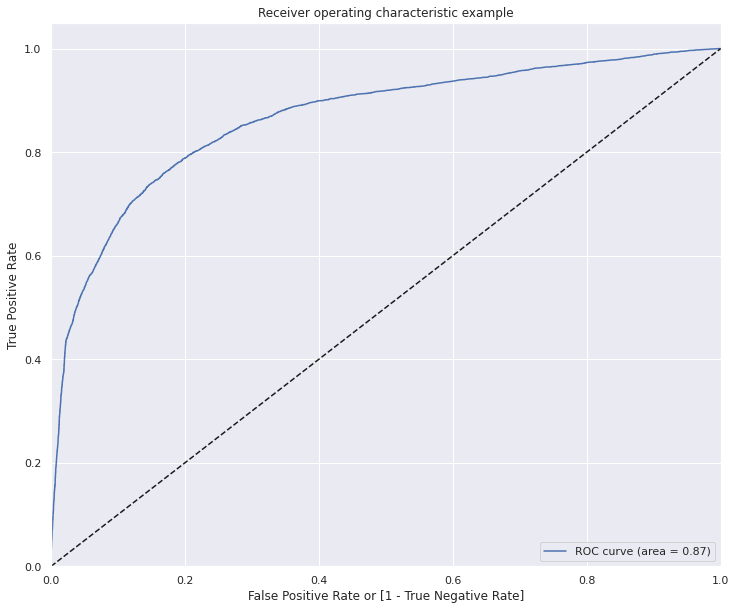

In [196]:
# Predicted probability
y_test_val_proba = xgb_adasyn_model.predict_proba(X_val.to_numpy())[:,1]
# Plot the ROC curve
draw_roc(y_val, y_test_val_proba)

### Catboost ADASYN

In [197]:
err=[]
y_pred_tot=[]

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1994)
for train_index, val_index in fold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    m = CatBoostClassifier(n_estimators=1000,random_state=1994,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=10)
    m.fit(X_train_adasyn, y_train_adasyn,eval_set=[(X_train_adasyn, y_train_adasyn),(X_val, y_val)], early_stopping_rounds=100,verbose=200)
    
    preds = m.predict_proba(X_val,ntree_end=m.best_iteration_)[:,-1]
    print("err: ",roc_auc_score(y_val, preds))
    err.append(roc_auc_score(y_val, preds))

0:	test: 0.7600340	test1: 0.8183181	best: 0.8183181 (0)	total: 152ms	remaining: 2m 32s
200:	test: 0.8083046	test1: 0.8743895	best: 0.8743895 (200)	total: 32.3s	remaining: 2m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8760241829
bestIteration = 297

Shrink model to first 298 iterations.
err:  0.8760192035006434
0:	test: 0.7600340	test1: 0.8117445	best: 0.8117445 (0)	total: 148ms	remaining: 2m 27s
200:	test: 0.8083046	test1: 0.8685024	best: 0.8685024 (200)	total: 32.3s	remaining: 2m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8704802465
bestIteration = 297

Shrink model to first 298 iterations.
err:  0.8704658848756741
0:	test: 0.7600340	test1: 0.8175524	best: 0.8175524 (0)	total: 139ms	remaining: 2m 18s
200:	test: 0.8083046	test1: 0.8715496	best: 0.8715513 (199)	total: 32.3s	remaining: 2m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8730213173
bestIteration = 297

Shrink model to first 298 iterations.
er

In [198]:
val_preds = m.predict_proba(X_val, ntree_end=m.best_iteration_)[:,-1]
# Plot the ROC curve
draw_roc(y_val, val_preds)